# Delaying Algorithm for jobFunnel Demonstration

## Module imports and installation:
<a id='mod'></a>

In [1]:
## Uncomment commented out code if any of these packages are missing.
#import sys, subprocess
#for pkg in ['scipy', 'matplotlib']: subprocess.check_call([sys.executable, "-m", "pip", "install", "--user", pkg])
from math import sqrt, exp, log
from typing import Union
from scipy.special import expit
from numpy import array, arange
from random import uniform
from matplotlib.patches import Polygon

import matplotlib.pyplot as plt

## Index:

[Module Imports and Installation](#mod)<br>
[Introduction](#intro)<br>
[Section 1. Math Functions for Delay Calculations](#sec_1)
- [Constant Delay](#cons)
- [Linear Delay](#lin)
- [Sigmoid Delay](#sig)
- [Side-by-Side Comparisons and Average Time Test](#comp)

[Section 2. Minimum Delay](#min_d)<br>
[Section 3. Random and Random Converging Delay](#rands)
- [Random Delay](#rand)
- [Converging Random Delay](#con_r)

[Section 4. Final Steps and Closing](#close)

## Introduction:
<a id='intro'></a>

In this notebook, I highlight how the delaying algorithm being used within Job Funnel works, which pre-calculates delay times for each job that needs to be scraped. It is configured using a few diffrent options set by the user to control the delaying behavior. The logic behind making this algorithm was provide a mechanism for not accidently DDoSing the job boards, and allowing the user to control delaying behavior.

I used [this article](https://streamhpc.com/blog/2012-07-16/how-expensive-is-an-operation-on-a-cpu/) to help code the math to be the least computationally expensive it could be. One thing to note, there were cases of more expensive operations being more efficient, this was because arthimetic between floats and integers were more inefficient then like type calculations. 

## 1. Math Functions for Delay Calculations
<a id='sec_1'></a>

The first step the algorithm takes is to check for a specified mathematical function out of three possible options and a for set delay value that acts as a horizontal asymptote. It then calculates the delay times based on the amount of scrape jobs, and returns a list of delay times. After that, it checks for a few more user specified options to determine the next steps for transforming the list, which are detailed way farther down. For now I will walk through the three functions being used below:

### Constant Delay
<a id='cons'></a>

The first function is a __constant__ function where *__y__* __=__ *__delay__*, which *should* work, if we weren't using a multithreaded scraper, in this case we need to add a little bit of complexity to it. Since our scraper has 8 workers, we need to set small offsets to our delay values so that each worker starts one after another instead of all at the same time. The logic for implementing this can be represented with a piecewise function, which is shown below, where __d__ is the delay, __i__ is the list index (Python indexes start at 0), and __n__ is the length of first 8 elements.

$$ f(i)=  \left\{
\begin{array}{ll}
      d - \frac{n-1}{5} + i\frac 1 5 & \text{if 1 }\leq i \leq 7\\
      d & \text{if }i \gt 7 \\
\end{array} 
\right. $$ 

$$ \text{Where } 1<n<8 $$

The last piece of the function are self explanatory, where as the middle piece is doing a few things. To start off, we first count up to the 8th scrape job or largest count value beforehand and subtract one(first element) from it. Then we divide that count by 5 and subtract that from delay for the 2nd through 8th elements. We then multiply the current index we are on by __1/5__ during each iteration and add that to our result. This ouputs a constant delay list with slightly reduced times to enable for proper scraper behavior. 

The implementation of which is shown in the code below and a graph of which is shown after.

In [2]:
def c_delay(scrape_job_list_length, delay):
    delays = [delay] * scrape_job_list_length
    increment = .2
    # Division by 5 is actually faster here, since they are both integers
    offset = len(delays[0:8])/5
    # for index, delay in enumrate(delays[0:8])
    #    delays[index] = index*increment + (delay-offset)
    delays[0:8] = [(d - offset) + i*increment for i, d in enumerate(delays[0:8])]
    return delays

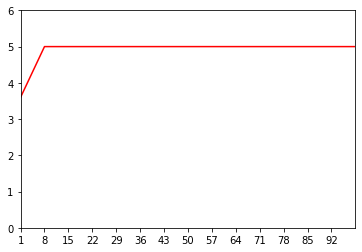

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(100), c_delay(100, 5), 'r')
ax.set(xlim=[1, 99], ylim=[0, 6])
plt.xticks(range(1, 97, 7))
plt.show()

### Linear Delay
<a id='lin'></a>

The next function is a __linear__ function, which is defined below using a piecewise function shown below. In this function our __i__ values are multiplied by our slope of __m = 1/5__, until __i__ is less than __5*delay__, which is the intersection of our linear function horizontal aymptote (delay). From there every value after the intersection is to our delay.

$$ f(i)=  \left\{
\begin{array}{ll}
      i\frac 1 5 & \text{if } i \lt 5d \\
      d & \text{if i} \geq 5d\\
\end{array} 
\right. $$ 

The implementation of this function is shown in the code below and a graph visualizaing its output is shown right after.

In [4]:
def lin_delay(scrape_job_list_length, delay):
    intersection = 5 * delay
    if intersection <= 1:
        # Calls constant delay if the intersection is to small
        return c_delay(scrape_job_list_length, delay)
    else:
        if isinstance(intersection, float):
            intersection = int(ceil(intersection))
            
        delays = [*range(scrape_job_list_length)]
        # The line of code below translates to:
        # for index in delays[0:intersection]:
        #    delays[0:intersection] = index / 5
        delays[0:intersection] = [i/5 for i in delays[0:intersection]]
        delays[intersection:] = [delay]*(len(delays) - intersection)
        return delays

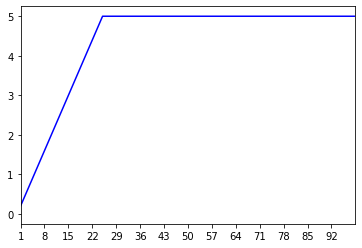

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(100), lin_delay(100, 5), 'b')
ax.set(xlim=[1, 99])
plt.xticks(range(1, 97, 7))
plt.show()

### Sigmoid Delay
<a id='sig'></a>

The generalized logisitc function(aka Richards Curve) is our final function, which is an extension of the __sigmoid__ function modified for precise control of the S curves behavior. More info can be found on it [here](https://en.wikipedia.org/wiki/Generalised_logistic_function) and [here](https://www.tjmahr.com/anatomy-of-a-logistic-growth-curve/). The equation we are using specifically is defined below:

$$ f(i)= \frac{d}{1+Q * e^{-B*i}} $$ 

$$ \text{Where }Q = 4d \text{  and  } B =\frac{1}{4 \sqrt d}$$

Here __Q__ controls our __Y(0)__, and __B__ is the growth rate that controls how our curve grows. Since coding these exact operations would make calculating this very slow, I used the [expit](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.expit.html) function found within scipy which calculates a sigmoid function based on the input __x__ . So this equation had to be re-written in a form that it can be plugged in as an __x__ value, which is shown below: 

$$ f(x)= \frac{1}{1+ e^{-x}}$$ 

$$ \text{Where }x = \frac{i}{4 \sqrt d}-\ln{\left(4d \right)}$$

The implementation of this rather verbose function is shown in the code below with a graph visualizing it outputs after.

In [6]:
def sig_delay(scrape_job_list_length, delay):
    gr = sqrt(delay)*4
    y_0 = log(4*delay)
    delays = delay * expit(arange(scrape_job_list_length)/gr - y_0)
    return delays

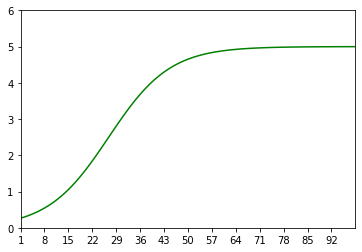

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(100), sig_delay(100, 5), 'g')
ax.set(xlim=[1, 99], ylim=[0, 6])
plt.xticks(range(1, 97, 7))
plt.show()

### Side-by-side Comparisons and Average Time Test
<a id='comp'></a>

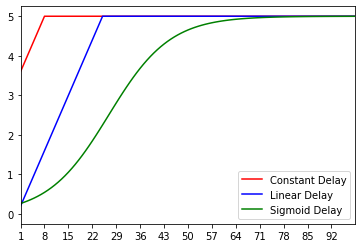

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(100), c_delay(100, 5), color='r', label='Constant Delay')
ax.plot(range(100), lin_delay(100, 5), color='b', label = 'Linear Delay')
ax.plot(range(100), sig_delay(100, 5), color='g', label = 'Sigmoid Delay')
ax.set(xlim=[1, 99])
ax.legend()
plt.xticks(range(1, 97, 7))
plt.show()

Here we test the average times our each functions takes to calculate a delay list for 10000 jobs using a delay of 15.

*Note: Calculations time will vary depending on the computer and Python version used.*

In [9]:
%timeit c_delay(10000, delay = 15)

31.2 µs ± 670 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
%timeit lin_delay(10000, delay = 15)

352 µs ± 4.46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%timeit sig_delay(10000, delay = 15)

204 µs ± 3.13 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 2. Minimum Delay
<a id='min_d'></a>

The second step is to check if the user specified a minimum delay value and sets minimum delay to elements in the list with delay times less than the minimum delay. The code for doing so is shown below with a graph visualizing the result:

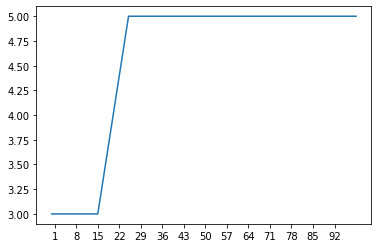

In [12]:
# Function definition
def min_delay(delay_list, minimum_delay):
    for index, delay in enumerate(delay_list):
        if delay > minimum_delay:
            break
        delay_list[index] = minimum_delay
    return delay_list

# Compute new delay list
minimum_delay = 3
delay_list = lin_delay(100, 5)
new_delay_list = min_delay(delay_list, minimum_delay)

# Plot out the results
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(100), new_delay_list)

plt.xticks(range(1, 97, 7))
plt.show()

## 3. Random and Converging Random Delay
<a id='rands'></a>

The third step checks if the user has specified random delaying, and if so, if the user specified to use something called converging delay. From there, it proceeds to calculate random delay times using [uniform()](https://docs.python.org/3.8/library/random.html#random.uniform) function from the built-in random module.

What the function does, is pick a random number (__N__) from a uniform distribution __(a <= N <= b)__, where __a__ and __b__ define the bounds our distribution to pick from. Our random functions will call __uniform(a,b)__ for every element in the delay times lists to randomize our delay times. 

Random Delay and Converging Random Delay are two diffrent implementations using this function which are explained below: 

### Random 
<a id='rand'></a>

Here __a = 0__ or __a = min_delay__ (if it was set), __b = calc_delay_times__, as uniform is called to iterate over every value in the delay list, the availble distribution of values to pick from grows larger until our asymptote(delay) is hit. The implementation code and graphs are shown below:

In [13]:
# Define random delay function
def random_delay(delay_list, min_delay = 0):
    # for index, delay in enumerate(delay_list):
    #     delays[index] = pick_random_num_between(minimum_delay, delay) 
    delays = [uniform(min_delay, delay) for delay in delay_list]
    return delays

For the graph part, I am gonna do a little something diffrent where I show all three functions with their areas highlighted (representing possible random values to pull from) and a line chart of some sample random values displayed on top of them.

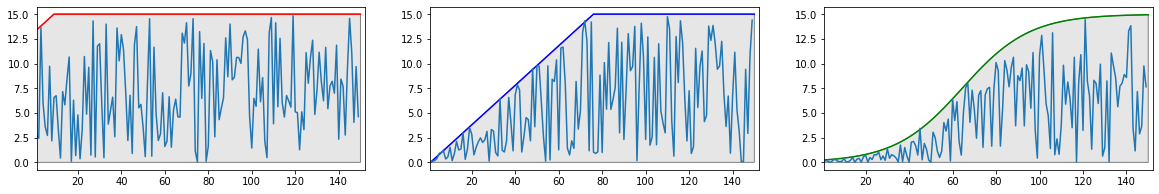

In [14]:
# Define function calculate Polygons
def calc_polygons(x, y):
    return Polygon([(0,0), *zip(x, y), (len(x), 0)] , facecolor='0.9', edgecolor='0.5')

# Define points on graph 
x = [*range(1,151)]
c_y = c_delay(len(x), 15)
l_y = lin_delay(len(x), 15)
r_y = sig_delay(len(x), 15)

# Setup our plot.
fig = plt.figure(figsize=(20,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, sharey = ax1)
ax3 = fig.add_subplot(133, sharey = ax1)

# Plot for Constant Delay 
ax1.plot(x, c_y, 'r')
ax1.plot(random_delay(c_y))
ax1.set(xlim=[1, 152])
# Plot for Linear Delay
ax2.plot(x, l_y, 'b')
ax2.plot(random_delay(l_y))
ax2.set(xlim=[1, 152])
# Plot for Sigmoid Delay
ax3.plot(x, r_y, 'g')
ax3.plot(random_delay(r_y))
ax3.set(xlim=[1, 152])
# Color in the ares under the curves
ax1.add_patch(calc_polygons(x, c_y))
ax2.add_patch(calc_polygons(x, l_y))
ax3.add_patch(calc_polygons(x, r_y))
plt.show()

### Converging Random Delay
<a id='con_r'></a>

What converging random delay does diffrent is that it sets __a = calc_delay_times__ and __b = delay__ instead. Here the distribution of random values gets smaller until the values of __a__ and __b__ converge. 
The implementation code and graphs are shown below:

In [15]:
# Define random delay function
def conv_random_delay(delay_list, max_delay):
    # for index, delay in enumerate(delay_list):
    #     delays[index] = pick_random_num_between(delay, max_delay) 
    delays = [uniform(delay, max_delay) for delay in delay_list]
    return delays

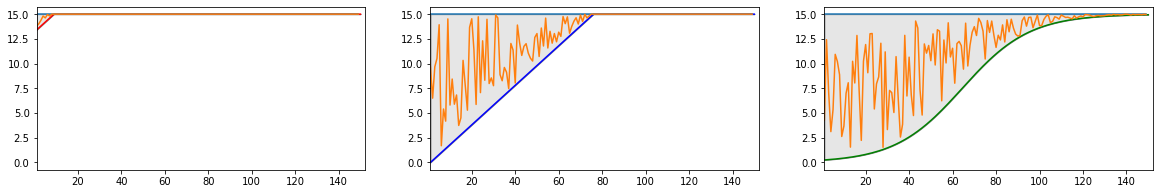

In [16]:
# Define points on graph 
x = [*range(1, 151)]
c_y = c_delay(len(x), 15)
l_y = lin_delay(len(x), 15)
r_y = sig_delay(len(x), 15)
max_delay_list = [15] * len(c_y)
# Setup our plot.
fig = plt.figure(figsize=(20,3))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, sharey = ax1)
ax3 = fig.add_subplot(133, sharey = ax1)

# Plot for Constant Delay 
ax1.plot(x, c_y, 'r')
ax1.plot(max_delay_list)
ax1.fill_between(x, c_y, max_delay_list, facecolor='0.9', edgecolor='0.5')
ax1.plot(conv_random_delay(c_y, 15))
ax1.set(xlim=[1, 152])

# Plot for Linear Delay
ax2.plot(x, l_y, 'b')
ax2.plot(max_delay_list)
ax2.fill_between(x, l_y, max_delay_list, facecolor='0.9', edgecolor='0.5')
ax2.plot(conv_random_delay(l_y, 15))
ax2.set(xlim=[1, 152])

# Plot for Sigmoid Delay
ax3.plot(x, r_y, 'g')
ax3.plot(max_delay_list)
ax3.fill_between(x, r_y, max_delay_list, facecolor='0.9', edgecolor='0.5')
ax3.plot(conv_random_delay(r_y, 15))
ax3.set(xlim=[1, 152])

plt.show()

## 4. Final Steps and Closing
<a id='close'></a>

After going through all the options, the algorithm then rounds the final results to the third decimal place and sets the first element to 0. Finally passing the resulting delay list off to the scraper to begin work. Thanks for reading and you can check out Job Funnel [here](https://github.com/PaulMcInnis/JobFunnel)